1. Data Description
The project uses two datasets from a Minecraft research server.
players.csv contains one row per player (196 players) with 7 variables: experience level, whether they subscribe to the game newsletter, a hashed email identifier, total hours played, name, gender, and age. On average, players are 21.14 years old (sd 7.39) and have played 5.85 hours (sd 28.36). Experience has five levels (Beginner, Amateur, Regular, Veteran, Pro). Gender includes several categories, which may need to be collapsed later to avoid very small groups. Age is missing for 2 players, which will require imputation or removal.
sessions.csv contains 1535 rows, one per play session. It records the player identifier, start and end time as readable strings, and numeric timestamps for start and end. End time is missing in 2 sessions. From this file we can compute session duration and approximate when players are active during the day.


2. Questions
Broad question:

How do player characteristics and play behaviour relate to engagement with a game related newsletter
Specific predictive question:

Can experience level, age, gender, and total hours played be used to predict whether a player subscribes to the newsletter


3. Exploratory Data Analysis and Visualization
First, I summarise quantitative variables in players.csv by computing the mean hours played and mean age. I will produce tables that compare mean played hours across experience levels and between subscribers and non subscribers. Preliminary summaries show that subscribers play far more hours on average than non subscribers and that Regular players have particularly high total hours.

Next, I will create several visualizations: a bar chart of experience distribution, a boxplot of played hours by subscription status, and a histogram of age. These plots will use clear axis labels, titles, and units of measurement. I will also join sessions to players by hashed email to compute the number of sessions per player and create a scatterplot of sessions versus total hours played to check for outliers and non linear patterns.


In [1]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
glimpse(players)
glimpse(sessions)


Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…
Rows: 1,535
Columns: 5
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_time          <chr> "30/06/2024 18:12", "17/06/2024 23:33", "25/07/202…
$ end_time            <chr> "30/06/2024 18:24", "17/06/2024 23:46", "25/07/202…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+

In [4]:
players %>% 
  summarise(
    mean_played_hours = round(mean(played_hours, na.rm = TRUE), 2),
    mean_age          = round(mean(Age, na.rm = TRUE), 2)
  )


mean_played_hours,mean_age
<dbl>,<dbl>
5.85,21.14


In [5]:
players %>% 
  group_by(subscribe) %>% 
  summarise(mean_hours = round(mean(played_hours, na.rm = TRUE), 2))

players %>% 
  group_by(experience) %>% 
  summarise(mean_hours = round(mean(played_hours, na.rm = TRUE), 2))


subscribe,mean_hours
<lgl>,<dbl>
FALSE,0.50
TRUE,7.78


experience,mean_hours
<chr>,<dbl>
Amateur,6.02
Beginner,1.25
Pro,2.60
Regular,18.21
Veteran,0.65


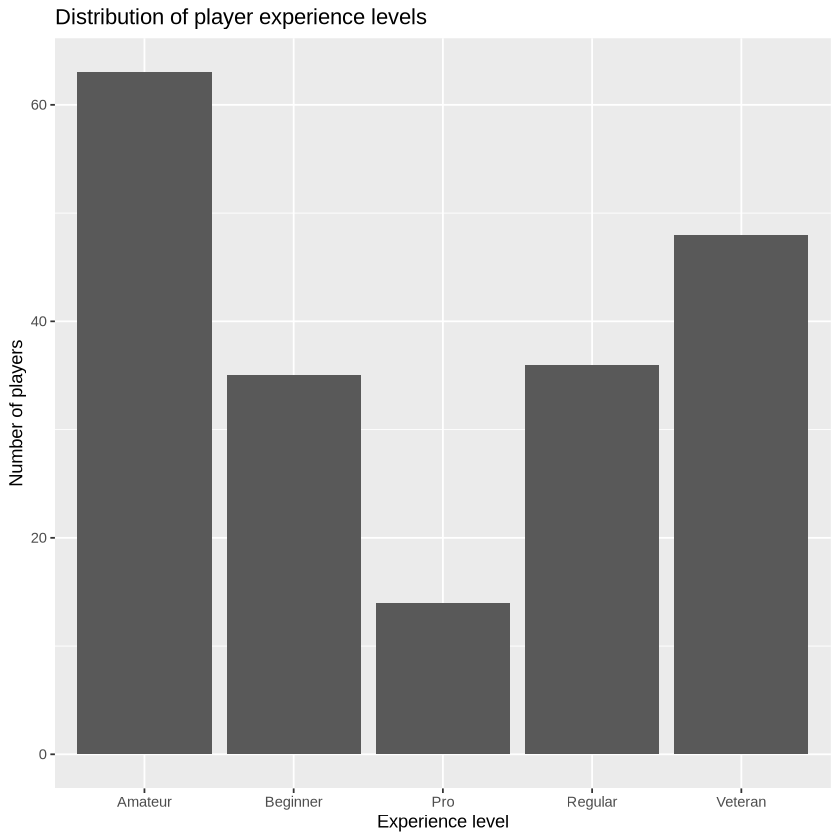

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


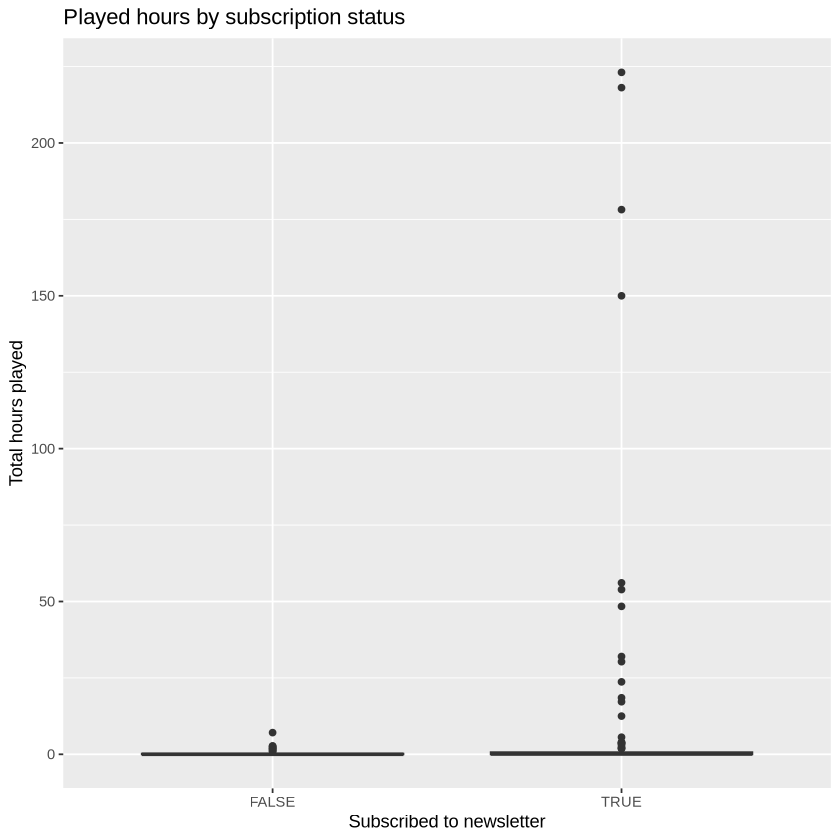

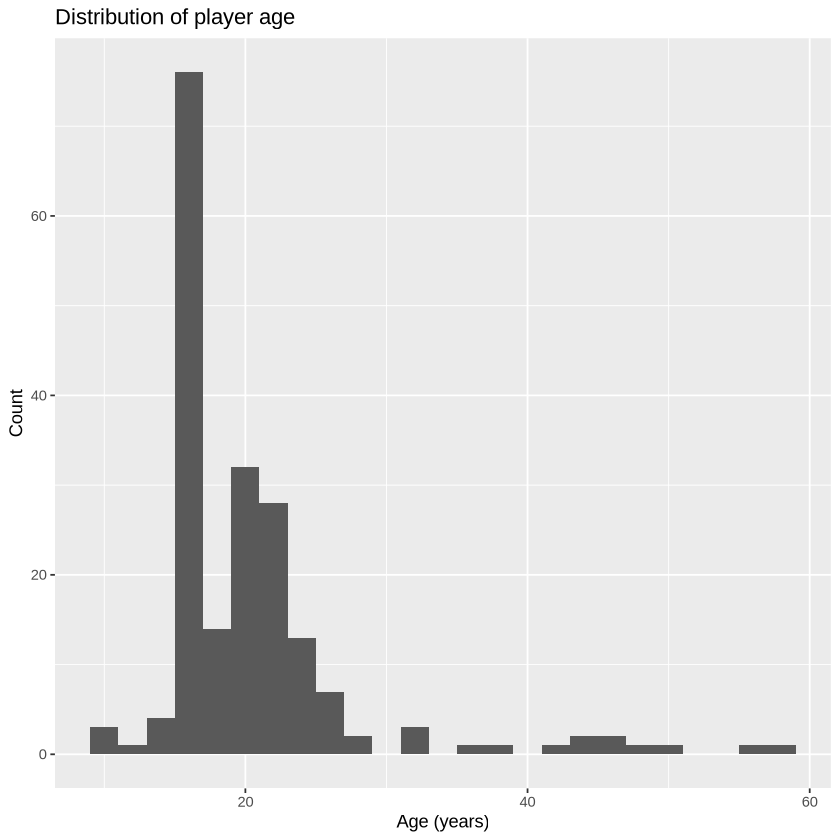

In [6]:
# Bar chart of experience levels
players %>% 
  ggplot(aes(x = experience)) +
  geom_bar() +
  labs(x = "Experience level", y = "Number of players",
       title = "Distribution of player experience levels")

# Boxplot of hours by subscription status
players %>% 
  ggplot(aes(x = subscribe, y = played_hours)) +
  geom_boxplot() +
  labs(x = "Subscribed to newsletter",
       y = "Total hours played",
       title = "Played hours by subscription status")

# Histogram of age
players %>% 
  ggplot(aes(x = Age)) +
  geom_histogram(binwidth = 2) +
  labs(x = "Age (years)", y = "Count",
       title = "Distribution of player age")


Warning message:
“Removed 71 rows containing missing values or values outside the scale range
(`geom_point()`).”


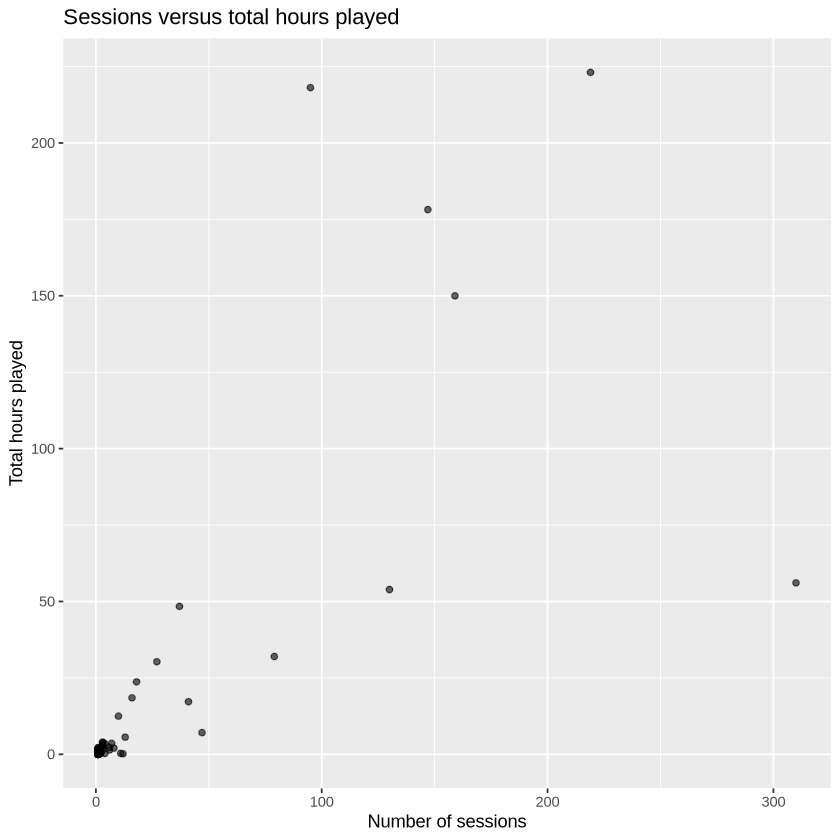

In [7]:
sessions_per_player <- sessions %>% 
  count(hashedEmail, name = "n_sessions")

players_sessions <- players %>% 
  left_join(sessions_per_player, by = "hashedEmail")

players_sessions %>% 
  ggplot(aes(x = n_sessions, y = played_hours)) +
  geom_point(alpha = 0.6) +
  labs(x = "Number of sessions",
       y = "Total hours played",
       title = "Sessions versus total hours played")


### Insights From the Plots

* The boxplot of played hours by subscription status shows a strong separation between the two groups. Players who subscribe to the newsletter tend to have much higher total hours played, while non-subscribers cluster close to zero. This suggests that overall engagement with the game is a major predictor of subscription behavior, making played hours an important variable for the model.

* The bar chart of experience levels indicates that most players fall into Amateur and Veteran categories, but some groups—such as Regular players—show much higher playtime overall. This pattern suggests that experience level may influence how invested a player becomes in the game, which could in turn affect their likelihood of subscribing.

* The histogram of age shows a wide distribution centered around late teens and early twenties. Because the distribution does not show a strong separation or unusual clusters, age may play a smaller role in predicting subscription compared to engagement-related variables.

* Overall, these plots suggest that behavioral variables, especially total hours played, are more informative than demographic variables for predicting newsletter subscription. These insights support using engagement metrics and experience level as key explanatory variables in the final predictive model.



### 4. Methods and Plan

To address the question of whether player characteristics can predict newsletter subscription, I plan to use logistic regression. This method is appropriate because the response variable, `subscribe`, is binary, and logistic regression is specifically designed to model the probability of an event occurring. It also provides interpretable coefficients, which will make it easier to understand how variables like played hours or experience level contribute to subscription likelihood.

Logistic regression requires several assumptions. The most important assumption is that there is a linear relationship between the predictors and the log-odds of the outcome. I will check this using diagnostic plots and consider transformations or interaction terms if needed. The method also assumes independent observations, which is reasonable here because each row represents a unique player. Additionally, the model can be affected by multicollinearity, so I will examine correlations between variables (e.g., age and experience) before fitting the model. If two predictors are strongly correlated, I may remove one or use regularization in alternative models.

Potential limitations of logistic regression include its sensitivity to outliers and non-linear relationships. For example, players with extremely high played hours could disproportionately influence the model. If the logistic regression does not capture the patterns well, I may compare it to more flexible models such as random forests or decision trees, which can model non-linear effects automatically. However, logistic regression is still a strong starting point given the interpretability requirement for this project.

To compare and select the final model, I will use cross-validation within the training set. This will allow me to evaluate multiple models (e.g., logistic regression vs. decision tree) using a consistent framework. Metrics such as accuracy, AUC, and misclassification error will help determine which model performs best. I will avoid using the test set until the final model has been selected to ensure an unbiased evaluation.

For data processing, I will first clean missing values, such as the two missing ages in `players.csv`. I may either remove those rows or impute age based on similar players. Categorical variables like gender and experience level will be encoded into dummy variables. I will then split the data into a training set (70%) and a test set (30%). All preprocessing steps will be applied to the training data first to avoid information leakage. If needed, I will scale or normalize numeric variables such as played hours to help the model converge or to support comparison with alternative methods.

Overall, this plan will allow me to build a well-justified, reproducible predictive model that addresses the main question while following best practices for model development.

